In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf
from sklearn.metrics import classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping

from sklearn.metrics import precision_recall_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import precision_score
import cv2
from PIL import Image
from multiprocessing import Pool
import warnings
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import os
import seaborn as sns
from tensorflow import keras

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers

# Define input shape
input_shape = (64, 64, 1)

# Define model architecture
model = keras.Sequential([
    keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 1)),
    keras.layers.Conv2D(16, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Conv2D(8, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Flatten(),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])

# Compile model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Print model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 30, 30, 16)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 8)         1160      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 14, 14, 8)        0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 1568)              0

In [ ]:
# Define data generators
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        '/content/drive/MyDrive/Group_Project_Data 2/Group_Project_Data/Train',
        target_size=(64, 64),
        color_mode='grayscale',
        batch_size=32,
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        '/content/drive/MyDrive/Group_Project_Data 2/Group_Project_Data/Valid',
        target_size=(64, 64),
        color_mode='grayscale',
        batch_size=32,
        class_mode='binary')



Found 6000 images belonging to 2 classes.
Found 1999 images belonging to 2 classes.


In [ ]:
# Define early stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',    # monitor validation loss
    patience=3,            # number of epochs with no improvement
    verbose=1,             # print messages when stopping
    restore_best_weights=True  # restore the best weights from the epoch with the lowest validation loss
)

In [ ]:
# Train model
history = model.fit(
        train_generator,
        steps_per_epoch=6000/32,
        epochs=10,
        validation_data=validation_generator,
        validation_steps=2000/32,
        callbacks=[early_stopping])

Epoch 1/10
187/187 [==============================] - 1909s 10s/step - loss: 0.1321 - accuracy: 0.9557 - val_loss: 0.0096 - val_accuracy: 0.9975
Epoch 2/10
187/187 [==============================] - 14s 74ms/step - loss: 0.0061 - accuracy: 0.9982 - val_loss: 0.0058 - val_accuracy: 0.9985
Epoch 3/10
 71/187 [==========>...................] - ETA: 6s - loss: 0.0030 - accuracy: 0.9987

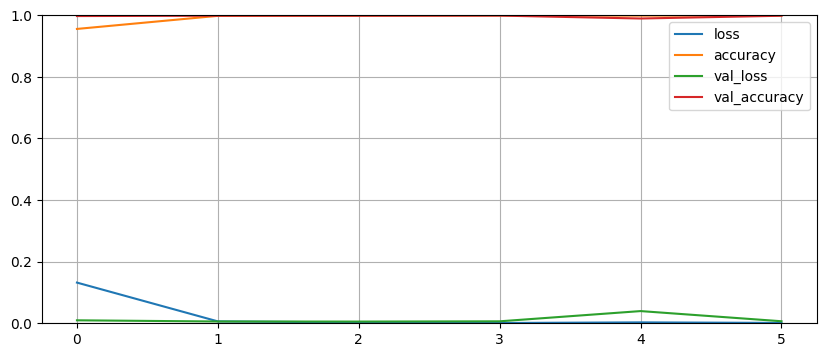

In [ ]:
plt.rcParams['figure.figsize']=(10,4)
pd.DataFrame(history.history).plot()
plt.grid()
plt.gca().set_ylim(0,1)
plt.show()

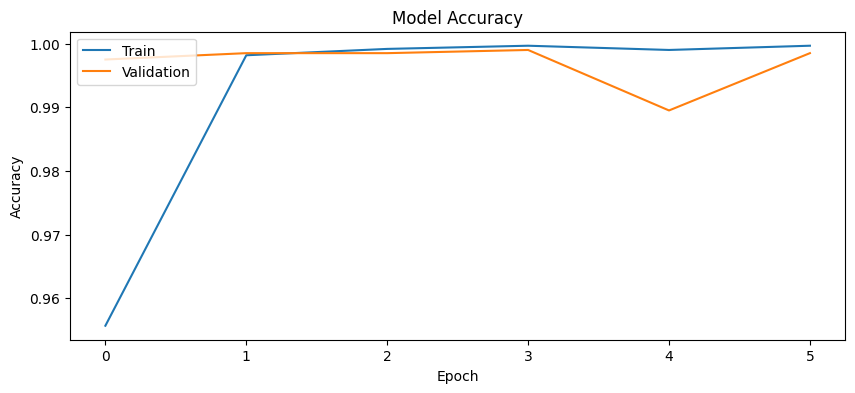

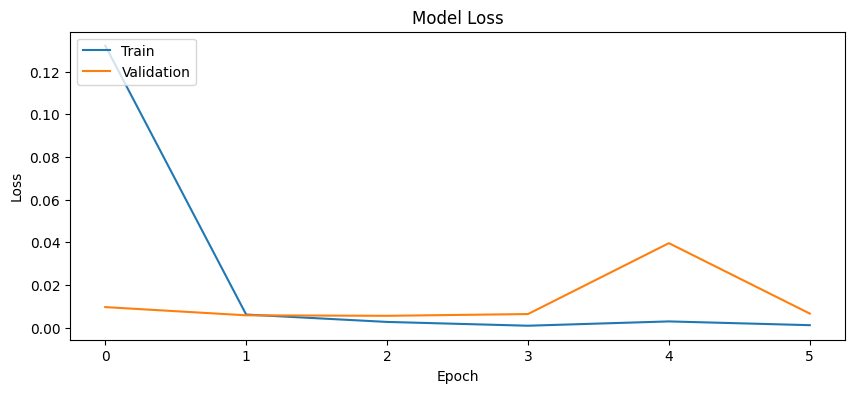

In [ ]:
# Plot the training and validation accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot the training and validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
test_generator = test_datagen.flow_from_directory(
        '/content/drive/MyDrive/Group_Project_Data 2/Group_Project_Data/Valid',
        target_size=(64, 64),
        color_mode='grayscale',
        batch_size=32,
        class_mode='binary')



Found 1999 images belonging to 2 classes.


In [ ]:
results = model.evaluate(test_generator)
print('Test loss: {:.3f}, Test accuracy: {:.3f}'.format(results[0], results[1]))

63/63 [==============================] - 4s 55ms/step - loss: 0.0056 - accuracy: 0.9985
Test loss: 0.006, Test accuracy: 0.998


63/63 [==============================] - 3s 49ms/step
Correctly classified:


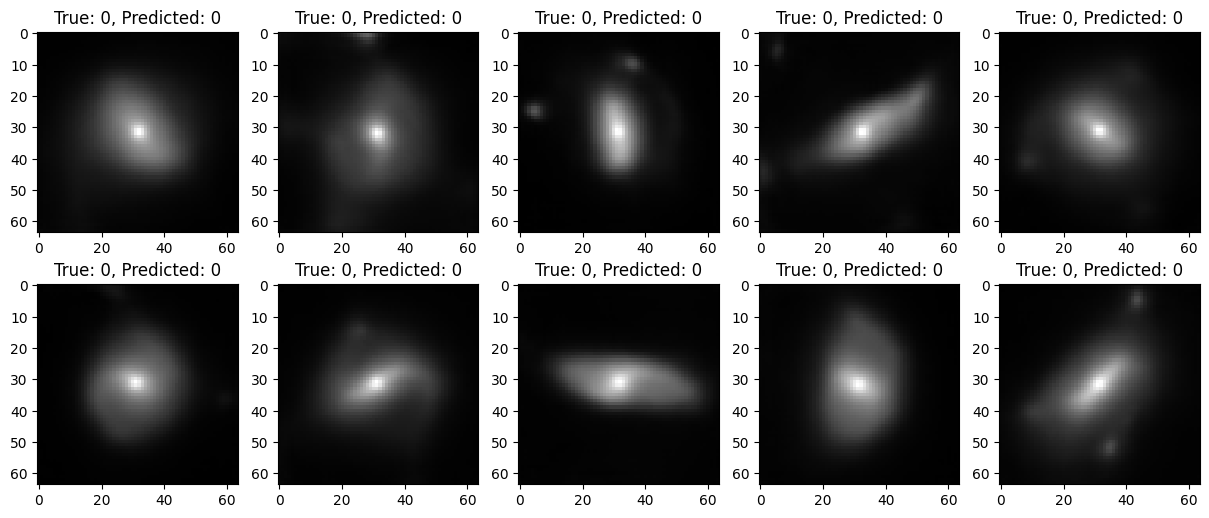

Incorrectly classified:


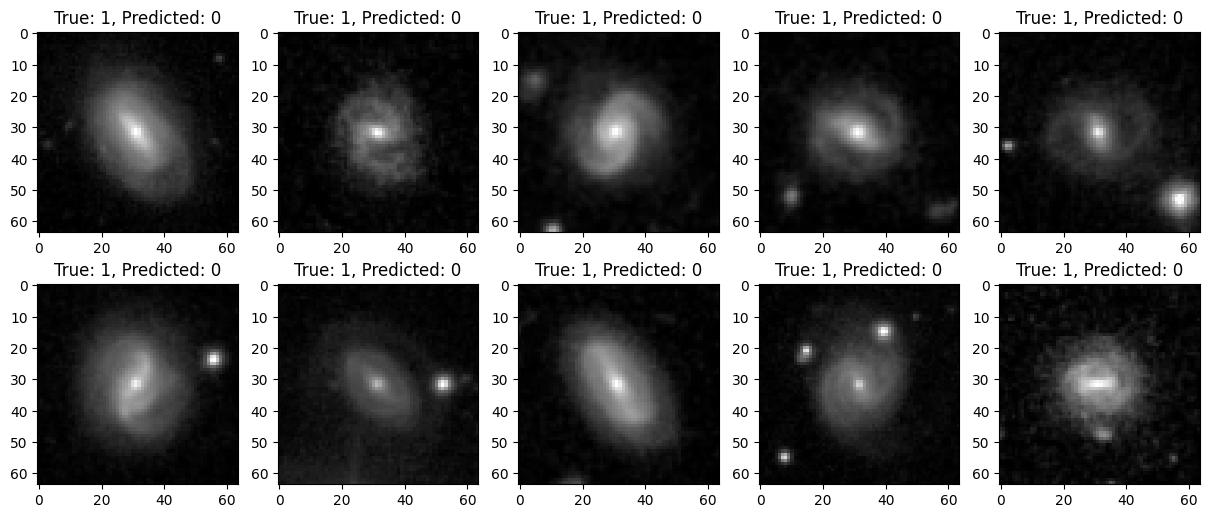

In [ ]:
# Get the labels for the test set
test_labels = test_generator.classes

# Make predictions on the test set
y_pred = model.predict(test_generator)
y_pred_ = np.argmax(y_pred, axis=1)

# Select correctly classified and misclassified indices for each class
correct_indices = np.where(y_pred_ == test_labels)[0]
incorrect_indices = np.where(y_pred_ != test_labels)[0]

# Load the test images
test_images = []
for file_path in test_generator.filepaths:
    img = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (64, 64))
    test_images.append(img)
test_images = np.array(test_images)

# Display some correctly classified images
print('Correctly classified:')
if len(correct_indices) > 0:
    fig, axes = plt.subplots(nrows=2, ncols=min(5, len(correct_indices)), figsize=(15, 6))
    for i, ax in enumerate(axes.flat):
        if i < len(correct_indices):
            img_idx = correct_indices[i]
            ax.imshow(test_images[img_idx], cmap='gray')
            ax.set_title(f"True: {test_labels[img_idx]}, Predicted: {y_pred_[img_idx]}")
        else:
            ax.axis('off')
    plt.show()
else:
    print('No images were correctly classified.')

# Display some incorrectly classified images
print('Incorrectly classified:')
if len(incorrect_indices) > 0:
    fig, axes = plt.subplots(nrows=2, ncols=min(5, len(incorrect_indices)), figsize=(15, 6))
    for i, ax in enumerate(axes.flat):
        if i < len(incorrect_indices):
            img_idx = incorrect_indices[i]
            ax.imshow(test_images[img_idx], cmap='gray')
            ax.set_title(f"True: {test_labels[img_idx]}, Predicted: {y_pred_[img_idx]}")
        else:
            ax.axis('off')
    plt.show()
else:
    print('No images were incorrectly classified.')


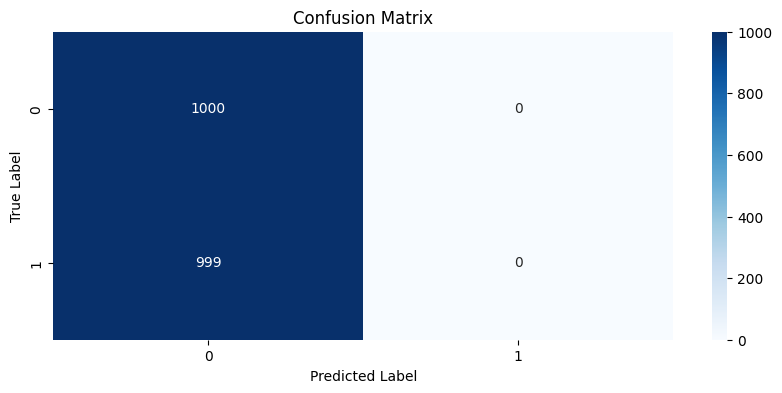

In [ ]:
conf_matrix = confusion_matrix(test_labels, y_pred_)

# Plot the confusion matrix using seaborn
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [ ]:
# Saving your model

#our_model.save('/content/Group_X_Model_Trained')

# Create a directory to save the model if it doesn't exist
if not os.path.exists('Group_X_Model_Trained'):
    os.makedirs('Group_X_Model_Trained')

# Save the model in the "models" directory
model.save('/content/Group_X_Model_Trained/our_model.h5')

In [ ]:
# Test saved model

loaded_model = tf.keras.models.load_model('/content/Group_X_Model_Trained/our_model.h5')
loaded_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 30, 30, 16)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 8)         1160      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 14, 14, 8)        0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 1568)              0

In [ ]:
# zip the model
!zip -r /content/Group_X_Model_Trained/our_model.h5.zip /content/Group_33_Model_Trained/our_model.h5

	zip warning: name not matched: /content/Group_33_Model_Trained/our_model.h5

zip error: Nothing to do! (try: zip -r /content/Group_X_Model_Trained/our_model.h5.zip . -i /content/Group_33_Model_Trained/our_model.h5)
